In [13]:
# The code relate to exeseries E

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def solve_for_k(k, Ω_R, Ω_M, H0):
    Ω_Λ = 1 - Ω_M - Ω_R
    H0 /= 3e5 # Convert H0 from km/s/Mpc to 1/Mpc

    def perturb_derivs(t, y):
        a, δ_r, θ_r, δ_m, θ_m, Φ = y

        # Time depente Ω's:
        Ω_r = Ω_R/a**4
        Ω_m = Ω_M/a**3
        Ω_tot = Ω_r + Ω_m + Ω_Λ

        # The Fredman equation
        H = H0 * Ω_tot**(1/2)

        a_prime = H * a**2

        # The equation from exeseries C:
        R_r = Ω_r / Ω_tot # Ω_R /( Ω_R + Ω_M*a + Ω_Λ*a**4 )
        R_m = Ω_m / Ω_tot # Ω_M /( Ω_R/a + Ω_M + Ω_Λ*a**3 )
        del_1 = - a*H*(1 + 1/3 * (k/(a*H))**2 )*Φ
        del_2 = 1/2 * a*H *(δ_m*R_m + δ_r*R_r)
        Φ_prime = del_1 + del_2

        # Equationes from exeseries D:
        δ_r_prime = - 4/3 * θ_r - 4*Φ_prime
        θ_r_prime = k**2 * (δ_r/4 - Φ)
        δ_m_prime = -θ_m - 3*Φ_prime
        θ_m_prime = -a*H*θ_m - k**2 *Φ

        return [a_prime, δ_r_prime, θ_r_prime, δ_m_prime, θ_m_prime, Φ_prime]
    
    η_ini = 0.1
    η_end = 15000
    η_span = np.logspace(np.log10(η_ini), np.log10(η_end), num=1000)

    # The initeriel condetion from exeseries E:
    a_ini = η_ini * H0 * Ω_R**(1/2)
    δ_r_ini = - 4/3
    θ_r_ini = k**2 * η_ini /3
    δ_m_ini = -1
    θ_m_ini = k**2 * η_ini /3
    Φ_ini = - 2/3

    y_ini = [a_ini, δ_r_ini, θ_r_ini, δ_m_ini, θ_m_ini, Φ_ini]
    
    sol = solve_ivp(perturb_derivs, [η_ini, η_span[-1]], y_ini, t_eval=η_span,
                    method='BDF', rtol=1e-6, atol=1e-10)

    
    return sol.t, sol.y
    


Cosmological parameters:
Omega_M = 0.300, Omega_R = 9.182e-05, H0 = 67.5 km/s/Mpc


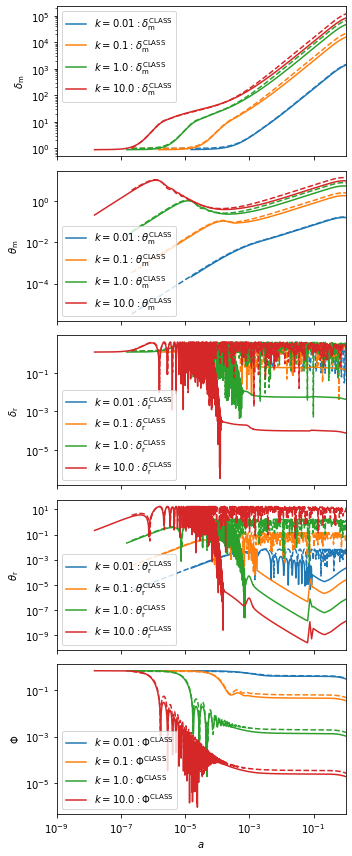

In [14]:
# Code relate to exeseries F
# This code is juste copyret form the one on bratspace:

import matplotlib.pyplot as plt
from classy import Class

klist = [0.01, 0.1, 1.0, 10.0]
cosmo = Class()
cosmo.set({'output':'mPk, dTk, vTk',
           'Omega_cdm':0.25,
           'Omega_b':0.05,
           'H0':67.5,
           'k_output_values':','.join(map(str,klist)),
           'gauge':'Newtonian',
               #'N_ur':0.0,'YHe':0.24,'Omega_b':0.001,
})
cosmo.compute()
Omega_M = cosmo.Omega_m()
Omega_R = cosmo.Omega_r()
H0 = cosmo.h()*100
# Print a nice comment that includes the values of Omega_M, Omega_R, and H0
print("Cosmological parameters:")
print("Omega_M = {:.3f}, Omega_R = {:.3e}, H0 = {:.1f} km/s/Mpc".format(Omega_M, Omega_R, H0))

pts = cosmo.get_perturbations()
fig, axes = plt.subplots(5, 1, figsize=(5, 12), sharex=True)
plotdict = {'delta_cdm':3, 'theta_cdm':4, 'delta_g':1, 'theta_g':2, 'phi':5}
tex_labels = {'delta_cdm':r'\delta_\mathrm{m}', 'delta_g':r'\delta_\mathrm{r}', 
              'theta_cdm':r'\theta_\mathrm{m}', 'theta_g':r'\theta_\mathrm{r}', 'phi':r'\Phi'}

for index_k, k in enumerate(klist):
    t, y = solve_for_k(k, Omega_R, Omega_M, H0)
    a = y[0]
    for index, (key, index_plot) in enumerate(plotdict.items()):
        ax = axes[index]
        tex_label = tex_labels[key]
        pts_k = pts['scalar'][index_k]
        l = ax.loglog(pts_k['a'], np.abs(pts_k[key]), label=f'$k={k}:' + tex_label + r'^\mathrm{CLASS}$')
        ax.loglog(a, np.abs(y[index_plot]), linestyle='--', color=l[0].get_color())
        ax.set_ylabel('$' + tex_label + '$')
        ax.legend(ncol=1)
axes[-1].set_xlabel('$a$')
axes[-1].set_xlim(1e-9, 1.0)
fig.tight_layout()
fig.savefig('perturbations.pdf', bbox_inches='tight')

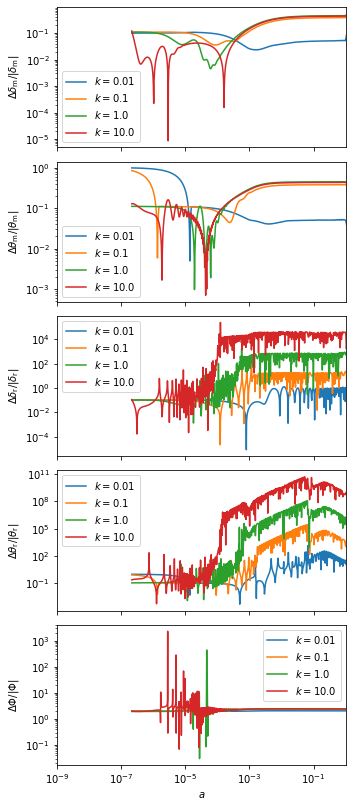

In [15]:
# Code relate to exeseries H

fig3, axes3 = plt.subplots(5, 1, figsize=(5, 12), sharex=True)

for index_k, k in enumerate(klist):
    t, y = solve_for_k(k, Omega_R, Omega_M, H0)
    a_num = y[0]
        
    for index, (key, index_plot) in enumerate(plotdict.items()):
        ax = axes3[index]
        tex_label = tex_labels[key]
        pts_k = pts['scalar'][index_k]

        class_vals = np.interp(a_num, pts_k['a'], pts_k[key])
        numeric_vals = y[index_plot]

        mask = np.abs(class_vals) > 1e-12
        relative_error = np.full_like(class_vals, np.nan)
        relative_error[mask] = np.abs((class_vals[mask] - numeric_vals[mask]) / class_vals[mask])

        ax.loglog(a_num, relative_error, label=f"$k={k}$")
        ax.set_ylabel(f"$\\Delta {tex_label}/|{tex_label}|$")
        ax.legend()

axes3[-1].set_xlabel('$a$')
axes3[-1].set_xlim(1e-9, 1.0)
fig3.tight_layout()
fig3.subplots_adjust(top=0.93)
fig3.savefig('perturbations_errors.pdf', bbox_inches='tight')